In [9]:
import re, time
from collections import OrderedDict

# Visualisation / Data handling
import pandas as pd
import seaborn as sns

# Cleaning and Preprocessing
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# Importing Gensim
import gensim
from gensim import corpora

# database 
from db_mongo import connect, get_db

connect('mongodb://server-grapefruit.quving.com:27027/textminer')
db_cursor = get_db().noz_en.find()

NUM_DOCUMENTS = 5000
NUM_TOPICS = 20
TESTSET_SIZE = 2

def get_texts(db_cursor, num_documents):
    actual_docs_count = 0
    content_dict0 = OrderedDict()
    for article in db_cursor.limit(num_documents):
        actual_docs_count += 1
        pattern = re.compile("-\d+")
        key = re.sub(pattern, '', article.get('slug'))
        content = article.get('content_en')
        if content:
            content_dict0[key] = content

    print(f"Using {len(content_dict0)} unique documents out of {actual_docs_count} total retrieved. ({num_documents} requested)")

    # for headline, content in content_dict0.items():
    #     print('KEY: '+str(headline))
    #     print('CONTENT: '+str(content))
    #     print()
    
    return content_dict0

In [10]:
def prepare_texts(content_dict0):
    doc_complete = [str(doc) for doc in content_dict0.values()]
    # doc_complete

    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    # exclude
    lemma = WordNetLemmatizer()
    def clean(doc):
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized

    doc_clean = [clean(doc).split() for doc in doc_complete]  
    # doc_clean
    # len(doc_clean)

    # Preparing Document-Term Matrix

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. 
    dictionary = corpora.Dictionary(doc_clean)
    # dictionary

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # doc_term_matrix

    return doc_complete, doc_clean, dictionary, doc_term_matrix

In [11]:
content_dict = get_texts(db_cursor, num_documents=NUM_DOCUMENTS)
keys_train = list(content_dict.keys())[:-TESTSET_SIZE]
keys_test = list(content_dict.keys())[-TESTSET_SIZE:]
print(f"{len(keys_train)} docs for training and {len(keys_test)} docs for testing.")

Using 1427 unique documents out of 2817 total retrieved. (5000 requested)
1425 docs for training and 2 docs for testing.


In [12]:
list(content_dict.keys())[:3]

['preise-fuer-kinderbefoerderung-in-der-gemeinde-berge-steigen',
 'keine-wohnung-fuer-frau-mit-zigeunereinschlag',
 'mit-dino-und-star-wars-so-argumentiert-ein-us-senator-gegen-klimaschutz']

In [13]:
content_dict_train = {k:v for k,v in content_dict.items() if k in keys_train}
doc_complete, doc_clean, dictionary, doc_term_matrix = prepare_texts(content_dict_train)
len(content_dict_train)

1425

In [14]:
content_dict_test = {k:v for k,v in content_dict.items() if k in keys_test}
doc_complete2, doc_clean2, dictionary2, doc_term_matrix2 = prepare_texts(content_dict_test)
# content_dict_test
len(content_dict_test)

2

In [15]:
set(content_dict_train.keys()) & set(content_dict_test.keys())  # should be empty, so no overlap

set()

In [16]:
import time
NUM_TOPICS = 20

In [17]:
# Running LDA Model
start_time = time.time()
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=NUM_TOPICS, id2word = dictionary, passes=50)
elapsed_time = time.time() - start_time
print(f"Training the LDA model with {len(doc_term_matrix)} documents took {elapsed_time} seconds.")

Training the LDA model with 1425 documents took 157.94126677513123 seconds.


In [18]:
topics = ldamodel.get_topics()

# Results

# print(ldamodel.print_topics(num_topics=5, num_words=3))
# ldamodel.print_topics(num_topics=-1, num_words=400)

for i in range(min(ldamodel.num_topics,3)):
    print(ldamodel.print_topic(i))
#     print()

0.016*"euro" + 0.010*"million" + 0.008*"federal" + 0.007*"said" + 0.006*"year" + 0.006*"company" + 0.005*"also" + 0.005*"according" + 0.005*"percent" + 0.004*"minister"
0.022*"school" + 0.016*"child" + 0.010*"year" + 0.009*"say" + 0.009*"student" + 0.008*"also" + 0.007*"parent" + 0.006*"care" + 0.005*"day" + 0.005*"work"
0.009*"also" + 0.007*"eu" + 0.006*"european" + 0.006*"said" + 0.006*"car" + 0.004*"new" + 0.004*"state" + 0.004*"time" + 0.003*"percent" + 0.003*"according"


In [69]:
# dictionary.id2token

In [19]:
import pandas as pd
import seaborn as sns

In [235]:
# df_topics = pd.DataFrame(ldamodel.get_topics())
# df_topics.rename(columns=dictionary.id2token, inplace=True)
# # df_topics['police']
# df_topics

## Visualise LDA model:

In [21]:
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
# pyLDAvis.enable_notebook()

In [236]:
# start_time = time.time()
# vis = pyLDAvis.gensim.prepare(ldamodel, corpus=doc_term_matrix, dictionary=dictionary)
# elapsed_time = time.time() - start_time
# print(f"Visualising the LDA model with {len(doc_term_matrix)} documents took {elapsed_time} seconds.")

In [23]:
# vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.117008  0.053073       1        1  19.811687
3      0.124076  0.088235       2        1   9.060587
14    -0.019667  0.094966       3        1   8.731497
19    -0.043705  0.031914       4        1   6.720511
1     -0.041401  0.133986       5        1   6.307930
18    -0.028636 -0.002069       6        1   5.048261
0     -0.104803 -0.100621       7        1   4.721593
17    -0.075264 -0.051003       8        1   4.621667
2     -0.063643 -0.088681       9        1   4.012866
5     -0.056851 -0.011394      10        1   3.786062
10     0.000307  0.064809      11        1   3.643908
11    -0.030945 -0.043221      12        1   3.203072
13     0.047764  0.065633      13        1   3.105501
9     -0.017303 -0.104819      14        1   2.856339
16     0.046518  0.027464      15        1   2.666825
7      0.010170  0.005333      16        1   2.546748
15     0.182450 -0.134653      17        1   2.507359
8     -0.006502 -0.037468      18        1   2.349444
6      0.145392 -0.004098      19        1   2.326441
4      0.049051  0.012615      20        1   1.971705, topic_info=     Category         Freq         Term        Total  loglift  logprob
512   Default   482.000000       police   482.000000  30.0000  30.0000
93    Default   592.000000       school   592.000000  29.0000  29.0000
3567  Default   500.000000            1   500.000000  28.0000  28.0000
52    Default   857.000000         euro   857.000000  27.0000  27.0000
1964  Default   432.000000         game   432.000000  26.0000  26.0000
34    Default   646.000000        child   646.000000  25.0000  25.0000
1621  Default   314.000000            2   314.000000  24.0000  24.0000
3627  Default   206.000000            0   206.000000  23.0000  23.0000
576   Default   378.000000      million   378.000000  22.0000  22.0000
1493  Default   408.000000         club   408.000000  21.0000  21.0000
505   Default   286.000000         fire   286.000000  20.0000  20.0000
1595  Default   424.000000         team   424.000000  19.0000  19.0000
274   Default  1124.000000          say  1124.000000  18.0000  18.0000
122   Default  1631.000000         year  1631.000000  17.0000  17.0000
1752  Default   212.000000       player   212.000000  16.0000  16.0000
844   Default   202.000000        coach   202.000000  15.0000  15.0000
1961  Default   272.000000     european   272.000000  14.0000  14.0000
273   Default  1220.000000         said  1220.000000  13.0000  13.0000
5345  Default   207.000000           eu   207.000000  12.0000  12.0000
1900  Default   304.000000      student   304.000000  11.0000  11.0000
1741  Default   126.000000           ii   126.000000  10.0000  10.0000
1980  Default   164.000000       league   164.000000   9.0000   9.0000
792   Default   129.000000          tax   129.000000   8.0000   8.0000
3568  Default   208.000000            3   208.000000   7.0000   7.0000
500   Default   321.000000          car   321.000000   6.0000   6.0000
581   Default   355.000000      percent   355.000000   5.0000   5.0000
1330  Default   165.000000     accident   165.000000   4.0000   4.0000
232   Default   437.000000       member   437.000000   3.0000   3.0000
1135  Default   277.000000         goal   277.000000   2.0000   2.0000
39    Default   351.000000    community   351.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
7478  Topic20     3.866581           sb     6.305380   3.4372  -7.3579
1383  Topic20    12.852826       person    96.272522   1.9127  -6.1567
75    Topic20    18.804588       number   259.315216   1.3023  -5.7761
122   Topic20    39.956638         year  1631.567261   0.2168  -5.0225
274   Topic20    32.477345          say  1124.084106   0.3821  -5.2297
2556  Topic20    14.887711        music   171.752792   1.4808  -6.0097
1344  Topic20     8.377247      cyclist    42.278851   2.3075  -6.5847


In [93]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

## Make docs-to-topics mapping:

In [142]:
def format_all_topics_for_documents(ldamodel, corpus, texts):
    min_prob_backup = ldamodel.minimum_probability
    ldamodel.minimum_probability = 0.0
    # Init output
    props_df = pd.DataFrame(columns=[i for i in range(NUM_TOPICS)], dtype='float64')

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            props_df.loc[i, topic_num] = prop_topic
#     props_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    column_map = {topic_num: f"Topic {topic_num}" for topic_num in range(NUM_TOPICS)}
    row_map = {doc_num: f"Doc {doc_num}" for doc_num in range(len(topics_df))}
    props_df.rename(column_map, axis='columns', inplace=True)
    props_df.rename(row_map, axis='index', inplace=True)

    ldamodel.minimum_probability = min_prob_backup
    return(props_df)
props_df = format_all_topics_for_documents(ldamodel=ldamodel, corpus=doc_term_matrix, texts=doc_clean)
props_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
Doc 0,0.711726,0.283631,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258
Doc 1,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.956308,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.039995
Doc 2,0.080242,0.000183,0.180296,0.509745,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.226788,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183
Doc 3,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.974975
Doc 4,0.478642,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.083364,0.000280,0.000280,0.000280,0.000280,0.433239,0.000280,0.000280
Doc 5,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.304913,0.000667,0.000667,0.000667,0.683072,0.000667,0.000667,0.000667,0.000667,0.000667
Doc 6,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.734739,0.251557,0.010429,0.000193,0.000193,0.000193,0.000193,0.000193
Doc 7,0.842358,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.154912,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152
Doc 8,0.000228,0.560467,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.435437
Doc 9,0.636857,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.336641,0.001472,0.001472,0.001472


In [121]:
props_df.sum(axis=1).unique()

array([1.00000048, 1.        , 1.00000024, 0.99999988, 1.00000012,
       0.99999976, 0.99999964, 0.99999994, 1.00000036, 0.99999982,
       0.99999952, 0.9999997 , 0.99999958, 0.99999946, 0.9999994 ])

In [136]:
props_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1425 entries, Doc 0 to 1424
Data columns (total 20 columns):
Topic 0     1425 non-null float64
Topic 1     1425 non-null float64
Topic 2     1425 non-null float64
Topic 3     1425 non-null float64
Topic 4     1425 non-null float64
Topic 5     1425 non-null float64
Topic 6     1425 non-null float64
Topic 7     1425 non-null float64
Topic 8     1425 non-null float64
Topic 9     1425 non-null float64
Topic 10    1425 non-null float64
Topic 11    1425 non-null float64
Topic 12    1425 non-null float64
Topic 13    1425 non-null float64
Topic 14    1425 non-null float64
Topic 15    1425 non-null float64
Topic 16    1425 non-null float64
Topic 17    1425 non-null float64
Topic 18    1425 non-null float64
Topic 19    1425 non-null float64
dtypes: float64(20)
memory usage: 233.8+ KB


In [75]:
len(doc_clean)

237

In [61]:
ldamodel.show_topic(3)

[('game', 0.013482442),
 ('team', 0.01034249),
 ('first', 0.0083170775),
 ('1', 0.0072027133),
 ('player', 0.006928568),
 ('coach', 0.0062770187),
 ('goal', 0.0058869077),
 ('second', 0.005832264),
 ('season', 0.0057932585),
 ('league', 0.0056367237)]

In [92]:
def get_topics_prettier(ldamodel, show_percentages=True):
    topics_df = pd.DataFrame()
    probs_df = pd.DataFrame()
    full_df = pd.DataFrame()
    for topic_num in range(NUM_TOPICS):    
        topic_data = ldamodel.show_topic(topic_num)
        for i, (term, prob) in enumerate(topic_data):
            topics_df.loc[i, topic_num] = f"{term}"
            probs_df.loc[i, topic_num] = prob
            full_df.loc[i, topic_num] = f"{term}: {prob*100:.3f}%"
    column_map = {topic_num: f"Topic {topic_num}" for topic_num in range(NUM_TOPICS)}
    row_map = {term_num: f"Term {term_num}" for term_num in range(len(topics_df))}
    topics_df.rename(column_map, axis='columns', inplace=True)
    topics_df.rename(row_map, axis='index', inplace=True)
    probs_df.rename(column_map, axis='columns', inplace=True)
    probs_df.rename(row_map, axis='index', inplace=True)
    full_df.rename(column_map, axis='columns', inplace=True)
    full_df.rename(row_map, axis='index', inplace=True)
    return topics_df, probs_df, full_df
topics_df, probs_df, full_df = get_topics_prettier(ldamodel, show_percentages=True)
topics_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
Term 0,euro,school,also,game,year,also,2,said,euro,may,one,european,also,member,also,1,formula,euro,time,police
Term 1,million,child,eu,team,say,year,1,year,tax,would,also,also,year,year,time,0,year,also,year,fire
Term 2,federal,year,european,first,also,said,0,also,year,brexit,say,copyright,new,club,say,2,time,million,said,also
Term 3,said,say,said,1,accident,group,tree,child,also,also,people,reform,city,board,year,ii,first,year,german,said
Term 4,year,student,car,player,number,boeing,say,court,said,vaccination,°,article,area,new,would,3,one,would,percent,case
Term 5,company,also,new,coach,according,euro,also,two,time,11,year,would,said,also,like,said,schumacher,district,also,accident
Term 6,also,parent,state,goal,concert,contribution,forest,new,müstak,said,market,filter,district,chairman,new,4,also,animal,would,say
Term 7,according,care,time,second,city,737,place,case,office,minister,c,eu,would,water,come,export,said,housing,first,city
Term 8,percent,day,percent,season,music,max,even,life,authority,measles,church,upload,work,family,want,goal,would,said,one,car
Term 9,minister,work,according,league,would,case,said,time,according,according,pastor,parliament,euro,work,one,migrant,say,wolf,change,two


In [76]:
# doc_clean[0]

In [77]:
# doc_complete[0]

In [78]:
# len(doc_term_matrix)

In [79]:
# doc_term_matrix

In [30]:
# whos
min_prob = ldamodel.minimum_probability 
min_prob

0.01

In [48]:
ldamodel.minimum_probability = 0.01

In [103]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=doc_term_matrix, texts=doc_clean)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.7117,"euro, million, federal, said, year, company, a...","[bus, transport, community, organizes, boy, gi..."
1,1,12.0,0.9561,"also, year, new, city, area, said, district, w...","[note, prospectus, sheet, clear, quot1, pers, ..."
2,2,3.0,0.5097,"game, team, first, 1, player, coach, goal, sec...","[ever, since, donald, trump, became, president..."
3,3,19.0,0.9750,"police, fire, also, said, case, accident, say,...","[47yearold, stopped, hitzacker, cat, wanted, c..."
4,4,0.0,0.4787,"euro, million, federal, said, year, company, a...","[profit, deutsche, bahn, declined, significant..."


In [104]:
df_dominant_topic.shape

(1425, 5)

In [27]:
ldamodel.__dict__

{'dtype': dtype('float32'),
 'id2word': <gensim.corpora.dictionary.Dictionary at 0x1331802e8>,
 'num_terms': 34776,
 'distributed': False,
 'num_topics': 20,
 'chunksize': 2000,
 'decay': 0.5,
 'offset': 1.0,
 'minimum_probability': 0.01,
 'num_updates': 1425,
 'passes': 50,
 'update_every': 1,
 'eval_every': 10,
 'minimum_phi_value': 0.01,
 'per_word_topics': False,
 'callbacks': None,
 'alpha': array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
       dtype=float32),
 'optimize_alpha': False,
 'eta': array([0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05], dtype=float32),
 'optimize_eta': False,
 'random_state': <mtrand.RandomState at 0x11c775360>,
 'iterations': 50,
 'gamma_threshold': 0.001,
 'dispatcher': None,
 'numworkers': 1,
 'state': <gensim.models.ldamodel.LdaState at 0x132619e10>,
 'expElogbeta': array([[3.7453996e-05, 3.7453996e-05, 3.7453996e-05, ..., 7.7721378e-14,
         7.7721378e-14, 7.7721

## PCA (brute force)

In [196]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [197]:
list(content_dict_train.keys())[:5]

['preise-fuer-kinderbefoerderung-in-der-gemeinde-berge-steigen',
 'keine-wohnung-fuer-frau-mit-zigeunereinschlag',
 'mit-dino-und-star-wars-so-argumentiert-ein-us-senator-gegen-klimaschutz',
 'auffahrunfall-wegen-einer-katze',
 'gewinn-der-deutschen-bahn-sinkt-auf-millionen-euro']

In [198]:
props_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
Doc 0,0.711726,0.283631,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258,0.000258
Doc 1,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.956308,0.000205,0.000205,0.000205,0.000205,0.000205,0.000205,0.039995
Doc 2,0.080242,0.000183,0.180296,0.509745,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.226788,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183,0.000183
Doc 3,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.001317,0.974975
Doc 4,0.478642,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.000280,0.083364,0.000280,0.000280,0.000280,0.000280,0.433239,0.000280,0.000280
Doc 5,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.304913,0.000667,0.000667,0.000667,0.683072,0.000667,0.000667,0.000667,0.000667,0.000667
Doc 6,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.000193,0.734739,0.251557,0.010429,0.000193,0.000193,0.000193,0.000193,0.000193
Doc 7,0.842358,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.154912,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152,0.000152
Doc 8,0.000228,0.560467,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.435437
Doc 9,0.636857,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.001472,0.336641,0.001472,0.001472,0.001472


In [199]:
# Separating out the features
x = props_df.values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x_df = pd.DataFrame(x)
x_df
# x_df.sum(axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3.994927,1.283685,-0.263953,-0.406640,-0.169122,-0.236943,-0.196319,-0.198232,-0.186922,-0.221057,-0.219597,-0.227153,-0.665072,-0.243421,-0.403040,-0.194367,-0.199967,-0.269479,-0.300547,-0.424429
1,-0.306889,-0.356857,-0.264285,-0.406883,-0.169555,-0.237297,-0.196815,-0.198625,-0.187338,-0.221404,-0.219976,-0.227513,2.857883,-0.243813,-0.403301,-0.194814,-0.200383,-0.269808,-0.300850,-0.239888
2,0.177011,-0.356986,0.872178,1.951886,-0.169739,-0.237447,-0.197027,-0.198792,-0.187515,-0.221551,-0.220138,-0.227666,0.169670,-0.243981,-0.403411,-0.195004,-0.200561,-0.269948,-0.300978,-0.424777
3,-0.300167,-0.350422,-0.257269,-0.401736,-0.160388,-0.229809,-0.186303,-0.190313,-0.178537,-0.214069,-0.211940,-0.219899,-0.661169,-0.235502,-0.397799,-0.185365,-0.191569,-0.262846,-0.294453,4.102182
4,2.585714,-0.356427,-0.263816,-0.406539,-0.168943,-0.236796,-0.196113,-0.198070,-0.186750,-0.220914,-0.219439,-0.227004,-0.358833,-0.243258,-0.402933,-0.194183,-0.199795,2.442113,-0.300422,-0.424328
5,-0.304095,-0.354182,-0.261369,-0.404744,-0.165745,-0.234184,-0.192446,-0.195170,-0.183680,-0.218355,1.982723,-0.224348,-0.663563,-0.240359,2.975921,-0.190887,-0.196720,-0.266914,-0.298191,-0.422527
6,-0.306966,-0.356930,-0.264365,-0.406942,-0.169660,-0.237383,-0.196936,-0.198721,-0.187439,-0.221488,-0.220068,-0.227600,2.041422,1.635306,-0.352709,-0.194922,-0.200484,-0.269888,-0.300923,-0.424732
7,4.784716,-0.357168,-0.264624,-0.407132,-0.169998,-0.237659,-0.197323,-0.199027,-0.187763,-0.221758,-0.220365,-0.227880,-0.095184,-0.244215,-0.403566,-0.195270,-0.200809,-0.270144,-0.301159,-0.424923
8,-0.306755,2.886086,-0.264145,-0.406780,-0.169372,-0.237147,-0.196606,-0.198459,-0.187162,-0.221257,-0.219816,-0.227361,-0.665184,-0.243648,-0.403191,-0.194625,-0.200208,-0.269669,-0.300722,1.596553
9,3.542272,-0.349523,-0.256290,-0.401018,-0.159108,-0.228763,-0.184836,-0.189153,-0.177308,-0.213044,-0.210818,-0.218836,-0.660597,-0.234342,-0.397031,-0.184046,2.467013,-0.261873,-0.293560,-0.418789


In [231]:
# x_diff = (x == x_old)
# x_old = x
# x_diff.all()

In [232]:
# pca = PCA(n_components=2)
pca = PCA()
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data=principalComponents)
# principal_df

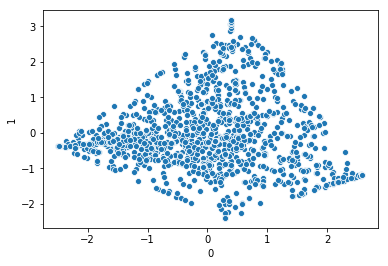

In [233]:
sns.scatterplot(x=principal_df[0], y=principal_df[1])

In [ ]:
def get_coords_for_text(content_dict_test):
    """
    Parameters
    ==========
    content_dict_test: dict
        mapping from some uuid to the text to be placed in the coord system    
    """
    
    # transform via LDA:
    doc_complete3, doc_clean3, dictionary3, doc_term_matrix3 = prepare_texts(content_dict_test)
    
    